Dans ce notebook vous trouverez de quoi charger les données de test qui vous sont fournies. Voici l'ordre des classes adopté : 

0. Chat
1. Lynx
2. Loup
3. Coyote
4. Jaguar
5. Guépard
6. Chimpanzé
7. Orang-Outan
8. Hamster
9. Cochon d'Inde
10. background

In [1]:
!git clone https://github.com/axelcarlier/testprojet.git

Cloning into 'testprojet'...


In [1]:
def class2num(c):
    id = -1
    if (c=='Chat'):
        id = 0
    elif (c=='Lynx'):
        id = 1
    elif (c=='Loup'):
        id = 2
    elif (c=='Coyote'):
        id = 3
    elif (c=='Jaguar'):
        id = 4
    elif (c=='Guépard'):
        id = 5
    elif (c=='Chimpanzé'):
        id = 6
    elif (c=='Orang-Outan'):
        id = 7
    elif (c=='Hamster'):
        id = 8
    elif (c=='Cochon d\'Inde'):
        id = 9
    else:
        print('Classe inconnue')
        
    return id
        
    

In [2]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

# Segmentation d'objet

In [3]:
def plot_training_analysis(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))
  
  plt.plot(epochs, acc, 'b', linestyle="--",label='Training accuracy')
  plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [4]:
import pylab as plt
import numpy as np
from matplotlib.path import Path

def create_mask(poly):

    width, height=64, 64

    #polygon=[(0.1*width, 0.1*height), (0.15*width, 0.7*height), (0.8*width, 0.75*height), (0.72*width, 0.15*height)]
    poly_path=Path(poly)

    x, y = np.mgrid[:height, :width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

    mask = poly_path.contains_points(coors)
    
    mask = np.transpose(mask.reshape(height, width))
    #plt.imshow(mask.reshape(height, width))
    #plt.show()
    
    return mask


In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json


images = np.zeros((100, 64, 64, 3))
masks = np.zeros((100, 64, 64))

index_img = 0
for file in range(10):
    start_image = file*10+1
    end_image = (file+1)*10
    
    json_file = 'annotations' + str(start_image) + '-' + str(end_image) + '.json'
    with open('testprojet/annotations/segmentation/' + json_file, 'r') as f:      
        data = json.load(f)
        
        for i in range(len(data['images'])):
            
            new_mask = 10*np.ones((64,64))
            
            data_img = data['images'][i]
            img_name = data_img['image']
            img = cv2.imread('testprojet/test/' + img_name)
            RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #plt.imshow(RGB_img)
            #plt.show()
            polygon_annotations = data_img['annotations'][0]['annotations']
            
            for m in range(len(polygon_annotations)):
                obj_class = polygon_annotations[m]['classId']
                mask = create_mask(np.array(polygon_annotations[m]['annotation']))
                new_mask[mask] = obj_class-1
                
            #plt.imshow(new_mask)
            #plt.show()
            
            
            images[index_img] = RGB_img
            masks[index_img] = new_mask
            index_img += 1

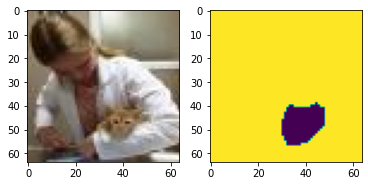

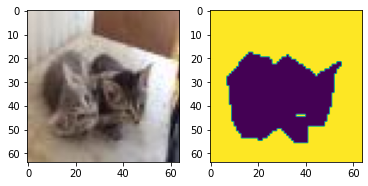

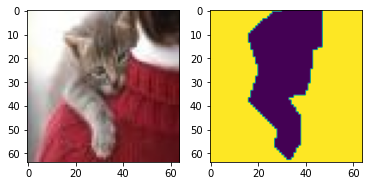

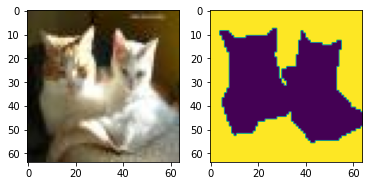

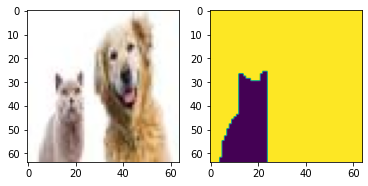

In [6]:
for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(images[i].astype('uint8'))
    plt.subplot(1,2,2)
    plt.imshow(masks[i])
    plt.show()

In [7]:
images.shape,masks.shape

((100, 64, 64, 3), (100, 64, 64))

In [8]:
y_test = np.zeros((100, 64, 64, 11))

for i in range(masks.shape[0]):
    for c in range(11):
        y_test[i, :, :, c] = np.where(masks[i]==c, 1, 0)

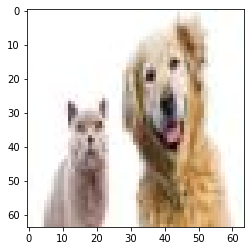

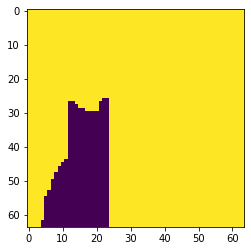

In [9]:
index = 4
plt.figure()
plt.imshow(images[index,:,:,:].astype('uint8'))
plt.figure()
plt.imshow(y_test[index,:,:,10])

In [10]:
from utils.dataloader import *

x,y = load_data()
print(x.shape,y.shape)

(311, 64, 64, 3) (311, 64, 64, 11)


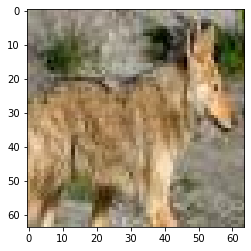

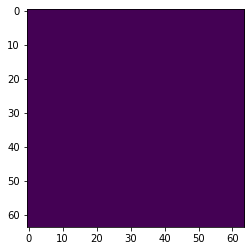

In [12]:
index = 96
plt.figure()
plt.imshow(x[index,:,:,:].astype('uint8'))
plt.figure()
plt.imshow(y[index,:,:,7])

In [13]:
y_test.shape
y_test_filtered = np.empty((0,64,64,11))
indices_filtered = []

In [14]:
for i in range(100):
    if np.max(y_test[i,:,:,[2,3,4,5,6,7]])>0:
        y_test_filtered = np.append(y_test_filtered,np.expand_dims(y_test[i],0),0)
        indices_filtered.append(i)

In [15]:
x_test_filtered = images[indices_filtered]

In [16]:
y_test_filtered.shape,x_test_filtered.shape

((60, 64, 64, 11), (60, 64, 64, 3))

In [17]:
from utils.affichage import *
import PIL
from PIL import Image
import numpy as np
import os
import re
import cv2

In [103]:
# Chemin vers la base de données
path = "./animals/unlabelled/"
# Indice d'ajout de données dans les variables x et y 
i = 0
# Préparation des structures de données pour x et y
x_unlabeled = np.zeros((50000, 64, 64, 3))

# Parcours des fichiers (classés) du répertoire
dirs = os.listdir(path)

# Trier les fichiers par nom alphanumérique
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)
dirs = sorted_alphanumeric(dirs)

for item in dirs:
  # Image : on va remplir la variable x
  # Lecture de l'image
  img = Image.open(path + item)
  # Remplissage de la variable x
  x_unlabeled[i] = np.asarray(img)
  i = i+1

x_unlabeled = x_unlabeled.astype('uint8')

In [18]:
# Chemin vers la base de données
path = "./animals/unlabelled_filtered/"
# Indice d'ajout de données dans les variables x et y 
i = 0
# Préparation des structures de données pour x et y
x_unlabeled_filtered = np.zeros((135, 64, 64, 3))

# Parcours des fichiers (classés) du répertoire
dirs = os.listdir(path)

# Trier les fichiers par nom alphanumérique
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)
dirs = sorted_alphanumeric(dirs)

for item in dirs:
  # Image : on va remplir la variable x
  # Lecture de l'image
  img = Image.open(path + item)
  # Remplissage de la variable x
  x_unlabeled_filtered[i] = np.asarray(img)
  i = i+1

x_unlabeled_filtered = x_unlabeled_filtered.astype('uint8')

In [69]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import UpSampling2D, concatenate
from keras import layers
from keras import models
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape, Input, Activation, BatchNormalization, PReLU
from keras.models import Model, Sequential
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2

l1 = 0
l2 = 0

reg = l1_l2(l1=l1,l2=l2)

def create_unet(image_size=64):
  input_layer=Input((image_size, image_size, 3))

  conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=reg)(input_layer)
  conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=reg)(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  
  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=reg)(pool1)
  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=reg)(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  
  conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=reg)(pool2)
  conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=reg)(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  
  conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=reg)(pool3)
  conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=reg)(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=reg)(pool4)
  conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=reg)(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=reg)(merge6)
  conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=reg)(merge7)
  conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=reg)(conv7)
  
  up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=reg)(merge8)
  conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=reg)(conv8)

  up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=reg)(merge9)
  conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',kernel_regularizer=reg)(conv9)
  conv10 = Conv2D(11, 1, activation = 'softmax')(conv9)


  model = Model(input_layer, conv10)

  return model

In [70]:
model = create_unet(image_size=64)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 64, 64, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 64, 64, 32)   9248        conv2d_46[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 32, 32, 32)   0           conv2d_47[0][0]                  
____________________________________________________________________________________________

In [21]:
from albumentations import (Compose, RandomBrightness, RandomContrast, RandomGamma, ShiftScaleRotate, CenterCrop, HorizontalFlip, RandomSizedCrop, Rotate, RandomScale, Resize )

AUGMENTATIONS_TRAIN = Compose([
    ShiftScaleRotate(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    HorizontalFlip(p=0.5)
])

AUGMENTATIONS_TRAIN2 = Compose([
    ShiftScaleRotate(p=1),
    RandomContrast(limit=0.2, p=1),
    RandomGamma(gamma_limit=(80, 120), p=1),
    RandomBrightness(limit=0.2, p=1),
    HorizontalFlip(p=0.5)
])

AUGMENTATIONS_TRAIN3 = Compose([
    Rotate(45,p=1),
    RandomScale(p=1),
    RandomContrast(limit=0.4, p=1),
    RandomGamma(gamma_limit=(80, 120), p=1),
    RandomBrightness(limit=0.3, p=1),
    HorizontalFlip(p=0.5),
    Resize(64,64,p=1)
])

AUGMENTATIONS_TRAIN4 = Compose([
    ShiftScaleRotate(p=0.9),
    RandomContrast(limit=0.2, p=0.9),
    RandomGamma(gamma_limit=(80, 120), p=0.9),
    RandomBrightness(limit=0.2, p=0.9),
    HorizontalFlip(p=0.5),
    RandomSizedCrop((48,48),64,64,p=0.9),
    Resize(64,64,p=1)
])

C:\Users\thips\anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:1770: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\thips\anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:1744: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [22]:
from keras.utils.data_utils import Sequence

class LSPDSequence(Sequence):
    # Initialisation de la séquence avec différents paramètres
    def __init__(self, x_set, y_set, batch_size, augmentations,nb_augment):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations
        self.indices1 = np.arange(x_set.shape[0]) 
        np.random.shuffle(self.indices1) # Les indices permettent d'accéder
        # aux données et sont randomisés à chaque epoch pour varier la composition
        # des batches au cours de l'entraînement
        self.nb_augment = nb_augment

    # Fonction calculant le nombre de pas de descente du gradient par epoch
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    # Application de l'augmentation de données à chaque image du batch et aux
    # cartes de probabilités associées
    def apply_augmentation(self, bx, by, n):
        """ n : number of transformations for each image in the batch"""
        batch_x = np.zeros((n*bx.shape[0],bx.shape[1],bx.shape[2],bx.shape[3]))
        batch_y = np.zeros((n*by.shape[0],by.shape[1],by.shape[2],by.shape[3]))
        # Pour chaque image du batch
        for i in range(len(bx)):
            masks = []
            # Les 14 masques associés à l'image sont rangés dans une liste pour 
            # pourvoir être traités par la librairie Albumentation
            for j in range(by.shape[3]):
                masks.append(by[i,:,:,j])

            img = bx[i]

            for t in range(n):
                # Application de l'augmentation à l'image et aux masques
                transformed = self.augment(image=img, masks=masks)
                batch_x[n*i+t] = transformed['image']
                batch_y_list = transformed['masks']

                # Reconstitution d'un tenseur à partir des masques augmentés
                for k in range(by.shape[3]):
                    batch_y[n*i+t,:,:,k] = batch_y_list[k]

        return batch_x/255, batch_y

    # Fonction appelée à chaque nouveau batch : sélection et augmentation des données
    def __getitem__(self, idx):
        batch_x = self.x[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
        batch_y = self.y[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
        
        batch_x, batch_y = self.apply_augmentation(batch_x, batch_y,self.nb_augment)

        return np.array(batch_x), np.array(batch_y)

    # Fonction appelée à la fin d'un epoch ; on randomise les indices d'accès aux données
    def on_epoch_end(self):
        np.random.shuffle(self.indices1)
        

In [161]:
train_gen = LSPDSequence(x.astype('uint8'), y, 32, augmentations=AUGMENTATIONS_TRAIN2,nb_augment=2)

In [ ]:
%matplotlib inline
batch_x, batch_y = train_gen.__getitem__(0)
plt.axis("off")
plt.imshow((255*batch_x[10]).astype('uint8'))
plt.figure()
plt.axis("off")
plt.imshow(batch_y[10,:,:,0])

In [ ]:
plt.axis("off")
plt.imshow(x[10].astype('uint8'))
plt.figure()
plt.axis("off")
plt.imshow(y[10,:,:,0])

In [162]:
model = create_unet(image_size=64)

# On utilise Adam, un optimiseur simple, et on va minimiser la MSE
# On affiche également la métrique MAE, qui nous permettra d'avoir une valeur plus interprétable
opt = keras.optimizers.Adam(learning_rate=3e-4) 

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics='accuracy')

# model.load_weights("model_weights/val_loss_min/20-1.26.hdf5")

# mcp_save = ModelCheckpoint('model_weights/val_loss_min2/{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only=True,save_weights_only=True, monitor='val_loss', mode='min')
mcp_save = ModelCheckpoint('model_weights/6classes_augment2_bs32_aug2_valloss{val_loss:.2f}.hdf5', save_best_only=True,save_weights_only=True, monitor='val_loss', mode='min')
# mcp_save = ModelCheckpoint('model_weights/all_epochs2/{epoch:02d}.hdf5', save_best_only=False,save_weights_only=True, monitor='val_accuracy', mode='max',save_freq=20*50)

history = model.fit(train_gen,
          epochs=100,validation_data=(x_test_filtered/255,y_test_filtered),
          callbacks=[mcp_save])

Epoch 1/100
10/10 [==============================] - 3s 138ms/step - loss: 2.2479 - accuracy: 0.2304 - val_loss: 1.6817 - val_accuracy: 0.5972
Epoch 2/100
10/10 [==============================] - 1s 121ms/step - loss: 1.7465 - accuracy: 0.4883 - val_loss: 1.3335 - val_accuracy: 0.6333
Epoch 3/100
10/10 [==============================] - 1s 118ms/step - loss: 1.6046 - accuracy: 0.4868 - val_loss: 1.3587 - val_accuracy: 0.6397
Epoch 4/100
10/10 [==============================] - 1s 119ms/step - loss: 1.5791 - accuracy: 0.5044 - val_loss: 1.3016 - val_accuracy: 0.6376
Epoch 5/100
10/10 [==============================] - 1s 117ms/step - loss: 1.5233 - accuracy: 0.5046 - val_loss: 1.2219 - val_accuracy: 0.6469
Epoch 6/100
10/10 [==============================] - 1s 117ms/step - loss: 1.5171 - accuracy: 0.5256 - val_loss: 1.2804 - val_accuracy: 0.6394
Epoch 7/100
10/10 [==============================] - 1s 125ms/step - loss: 1.4891 - accuracy: 0.5165 - val_loss: 1.1791 - val_accuracy: 0.6509

In [74]:
model = models.load_model('model_weights/.augment2_bs32_aug1.hdf5')
# model.load_weights("model_weights/val_loss_min/18-0.81.hdf5")
model.evaluate(x_test_filtered/255,y_test_filtered),model.evaluate(x/255,y)

10/10 [==============================] - 0s 25ms/step - loss: 0.4023 - accuracy: 0.8472


([0.7871264219284058, 0.7372599244117737],
 [0.4023163914680481, 0.8472362756729126])

In [82]:
import seaborn
from utils.metrics import confusion_matrix

In [85]:
%matplotlib qt
model.load_weights('model_weights/.augment2_bs32_aug1.hdf5')
confusion_matrix(model,x_test_filtered,y_test_filtered)
# confusion_matrix(model,x,y)

c:\Users\thips\Documents\N7\3A\Deep Learning\segmentation-deep-learning-project\utils\metrics.py:22: RuntimeWarning: invalid value encountered in true_divide
  matrix[i,:] = matrix[i,:]/count_pix_class[i]


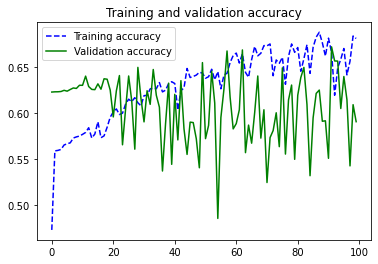

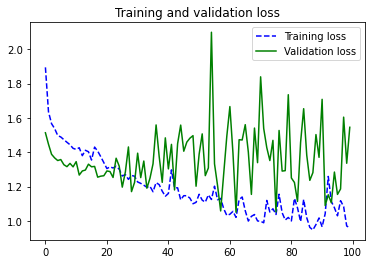

In [89]:
%matplotlib inline
plot_training_analysis(history)

In [48]:
y_test[0,:,:,:10].shape

(64, 64, 10)

In [54]:
y_test[0,:,:,:10].shape

(64, 64, 10)

In [53]:
np.argmax(y_test[0,:,:,:10],2).shape

(64, 64)

In [40]:
%matplotlib inline

In [ ]:
# 20, 40
model.load_weights('model_weights/.student1352_0.hdf5')
ind_img = 60
ind = 6

prediction = model.predict(np.expand_dims(images[ind_img], axis=0))
plt.axis("off")
plt.imshow(prediction[0,:,:,ind])
plt.show()
plt.axis("off")
plt.imshow(images[ind_img].astype('uint8'))
plt.show()
plt.axis("off")
plt.imshow(y_test[ind_img,:,:,ind])
plt.show()

In [30]:
prediction[0,:,:,ind][0,0]

1.0

In [87]:
train_gen = LSPDSequence(x.astype('uint8'), y, 32, augmentations=AUGMENTATIONS_TRAIN,nb_augment=2)
batch_x, batch_y = train_gen.__getitem__(0)

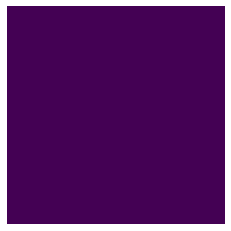

In [76]:
plt.axis("off")
plt.imshow(batch_y[38,:,:,5].astype('uint8'))

In [125]:
import random

In [129]:
len(x_unlabeled)

50000

In [130]:
random.randrange(0,len(x_unlabeled))

4189

In [86]:
AUGMENTATIONS_TRAIN = Compose([
    ShiftScaleRotate(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    HorizontalFlip(p=0.5)
])

C:\Users\thips\anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:1770: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\thips\anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:1744: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [88]:
nb_students = 1
nb_new_images = 135

# teacher = models.load_model("model_weights/.all_classes_augment2_bs32_aug2_bis.hdf5")
teacher = models.load_model("model_weights/.student1352_0.hdf5")

for i in range(nb_students):

    indices_new_images = np.random.randint(0,len(x_unlabeled_filtered),size=nb_new_images)

    x_new = x_unlabeled_filtered#[indices_new_images]
    y_new = teacher.predict(x_new)

    x_mixed = np.append(x,x_new,axis=0)
    y_mixed = np.append(y,y_new,axis=0)

    train_gen = LSPDSequence(x_mixed.astype('uint8'), y_mixed, 32, augmentations=AUGMENTATIONS_TRAIN,nb_augment=2)

    student = create_unet(image_size=64)
    opt = keras.optimizers.Adam(learning_rate=3e-4)

    student.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics='accuracy')

    mcp_save = ModelCheckpoint('model_weights/.student1352_'+str(i)+'.hdf5', save_best_only=True, monitor='val_loss', mode='min')
    
    history = student.fit(train_gen,
            epochs=100,validation_data=(x_test_filtered/255,y_test_filtered),
            callbacks=[mcp_save])
    

Epoch 1/100
14/14 [==============================] - 7s 251ms/step - loss: 1.9336 - accuracy: 0.4666 - val_loss: 1.4122 - val_accuracy: 0.6359
Epoch 2/100
14/14 [==============================] - 1s 78ms/step - loss: 1.4752 - accuracy: 0.5375 - val_loss: 1.2221 - val_accuracy: 0.6382
Epoch 3/100
14/14 [==============================] - 1s 78ms/step - loss: 1.3872 - accuracy: 0.5517 - val_loss: 1.1368 - val_accuracy: 0.6410
Epoch 4/100
14/14 [==============================] - 1s 78ms/step - loss: 1.3347 - accuracy: 0.5656 - val_loss: 1.1141 - val_accuracy: 0.6487
Epoch 5/100
14/14 [==============================] - 1s 78ms/step - loss: 1.2779 - accuracy: 0.5831 - val_loss: 0.9989 - val_accuracy: 0.6805
Epoch 6/100
14/14 [==============================] - 1s 79ms/step - loss: 1.2222 - accuracy: 0.5962 - val_loss: 1.0100 - val_accuracy: 0.6722
Epoch 7/100
14/14 [==============================] - 1s 79ms/step - loss: 1.2076 - accuracy: 0.5927 - val_loss: 0.9575 - val_accuracy: 0.6915
Epoch

In [90]:
model_evaluate = models.load_model("model_weights/.student1352_0.hdf5")
model_evaluate.evaluate(x_test_filtered/255,y_test_filtered)

2/2 [==============================] - 0s 20ms/step - loss: 0.6858 - accuracy: 0.7582


[0.6857692003250122, 0.7582234740257263]

In [91]:
%matplotlib qt
confusion_matrix(model_evaluate,x_test_filtered,y_test_filtered)

c:\Users\thips\Documents\N7\3A\Deep Learning\segmentation-deep-learning-project\utils\metrics.py:22: RuntimeWarning: invalid value encountered in true_divide
  matrix[i,:] = matrix[i,:]/count_pix_class[i]


In [93]:
%matplotlib inline

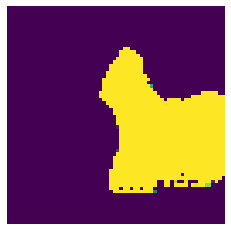

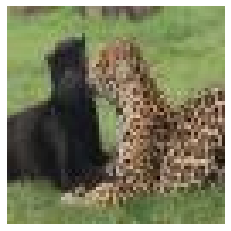

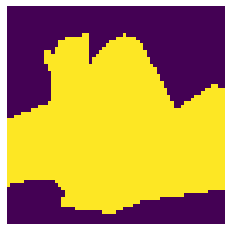

In [102]:
ind_img = 42
ind = 4

prediction = model_evaluate.predict(np.expand_dims(images[ind_img], axis=0))
plt.axis("off")
plt.imshow(prediction[0,:,:,ind])
plt.show()
plt.axis("off")
plt.imshow(images[ind_img].astype('uint8'))
plt.show()
plt.axis("off")
plt.imshow(y_test[ind_img,:,:,ind])
plt.show()

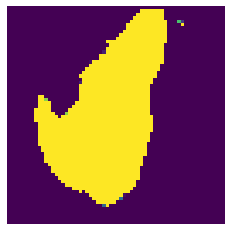

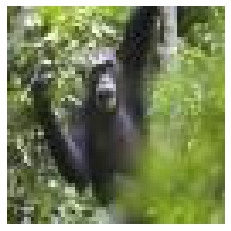

In [154]:
ind_img = 18848
ind = 6

prediction = model_evaluate.predict(np.expand_dims(x_unlabeled[ind_img], axis=0))
plt.axis("off")
plt.imshow(prediction[0,:,:,ind])
plt.show()
plt.axis("off")
plt.imshow(x_unlabeled[ind_img].astype('uint8'))
plt.show()